# Analysis of Underwater Wind Noise using OOI Hydrophones

This notebook provides a brief demonstration of underwater wind noise analysis at the NE Pacific continental margin. Raw acoustic and meteorological data were recorded in September 2015 and June 2019 by two hydrophones and two surface buoys deployed off the coast of Oregon, at the continental slope and shelf, respectively, as part of the OOI program. 

The raw data, along with the preprocessing and cleaning steps, are described in detail in [this paper](https://pubs.aip.org/asa/jasa/article/150/6/4166/993696/Statistical-analysis-and-modeling-of-underwater). 

Here, we use the preprocessed data to illustrate the dependence of underwater noise on surface wind.  

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.optimize import curve_fit

# Loading and Parsing Data from JSON Files
In this section, we load acoustic and meteorological data stored in JSON files. Each file contains time-aligned metadata, power spectral density (PSD) estimates, and environmental variables (e.g., wind speed, rainfall).

We use Python’s built-in json module to read the data and convert the relevant fields into structured pandas DataFrames for easier analysis and visualization.

**Important Note: Parsing the data may take several minutes to complete.**

In [13]:
%%time
# Base directory
base_path = '/home/jovyan/ooi/rsn_cabled/SummerSchool2025/rain_wind_psd/shelf_PSD_organized'

# List to collect all data
records = []

# Get list of subfolders in base_path (only take the first two)
subfolders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
#selected_folders = sorted(subfolders)[:200]  # You can adjust sorting or selection as needed
selected_folders = subfolders[:200]  # You can adjust sorting or selection as needed

# Loop through the selected folders
for folder in selected_folders:
    folder_path = os.path.join(base_path, folder)
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                filepath = os.path.join(root, file)

                try:
                    with open(filepath, 'r') as f:
                        data = json.load(f)

                    # Collect desired fields
                    record = {
                        'file_path': filepath,
                        'windspeed': data.get('windspeed'),
                        'windangle': data.get('windangle'),
                        'rainrate': data.get('rainrate'),
                        'starttime': data.get('starttime'),
                        'endtime': data.get('endtime'),
                        'psd': data.get('psd'),
                        'frequency': data.get('frequency')
                    }

                    records.append(record)

                except Exception as e:
                    print(f"Failed to read {filepath}: {e}")

# Create DataFrame
df = pd.DataFrame(records)

# Display summary
print(f"\nTotal files processed: {len(df)}")
print(df.head())



Total files processed: 11802
                                           file_path  windspeed  windangle  \
0  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.973370   1.869692   
1  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.844700   1.879653   
2  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   8.185824   1.751902   
3  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   7.912677   1.833992   
4  /home/jovyan/ooi/rsn_cabled/SummerSchool2025/r...   8.108447   1.857907   

  rainrate            starttime              endtime  \
0     None  2016-10-27 00:14:14  2016-10-27 00:15:19   
1     None  2016-10-27 00:15:19  2016-10-27 00:16:23   
2     None  2016-10-27 00:04:03  2016-10-27 00:05:07   
3     None  2016-10-26 23:51:04  2016-10-26 23:52:10   
4     None  2016-10-27 00:13:10  2016-10-27 00:14:14   

                                                 psd  \
0  [61.29861715862992, 70.31524485863213, 74.2788...   
1  [61.35762779013626, 70.70609696574036, 74.1463...

# Plotting Sample Power Spectral Densities (PSDs)

In this section, we visualize a subset of the power spectral density (PSD) estimates to explore the spectral characteristics of the underwater acoustic data. Each PSD represents the sound energy distribution across frequencies for a given time segment (1-min).

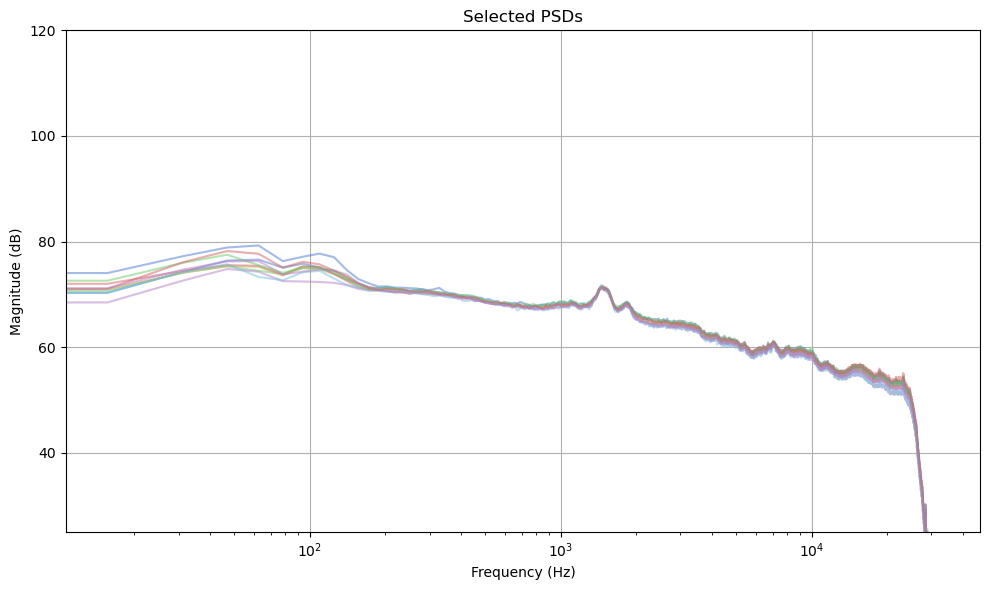

In [14]:
# Optional: set figure size and style
plt.figure(figsize=(10, 6))
#plt.style.use('seaborn-v0_8-muted')

# Plot selected PSDs
for i, row in df[0:10].iterrows():
    freq = row['frequency']
    psd = row['psd']
    
    if freq and psd:  # Make sure they're not empty
        plt.plot(freq, psd, alpha=0.5, label=f'{os.path.basename(row["file_path"])}')

# Set plot options
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Selected PSDs')
plt.ylim(25, 120)
plt.grid(True)

# Optional: show legend (can be crowded with many files)
# plt.legend()

plt.tight_layout()
plt.show()


# Plotting PSDs by Wind Speed Range

Here, we group the data by wind speed ranges and plot the corresponding PSDs. 

We define wind speed bins and then plot a few PSDs from each category. This visualization helps identify trends, such as increased high-frequency noise during higher wind speeds due to surface agitation and bubble formation.

This section generates a plot similar to Figure 4 in [this paper](https://pubs.aip.org/asa/jasa/article/150/6/4166/993696/Statistical-analysis-and-modeling-of-underwater)

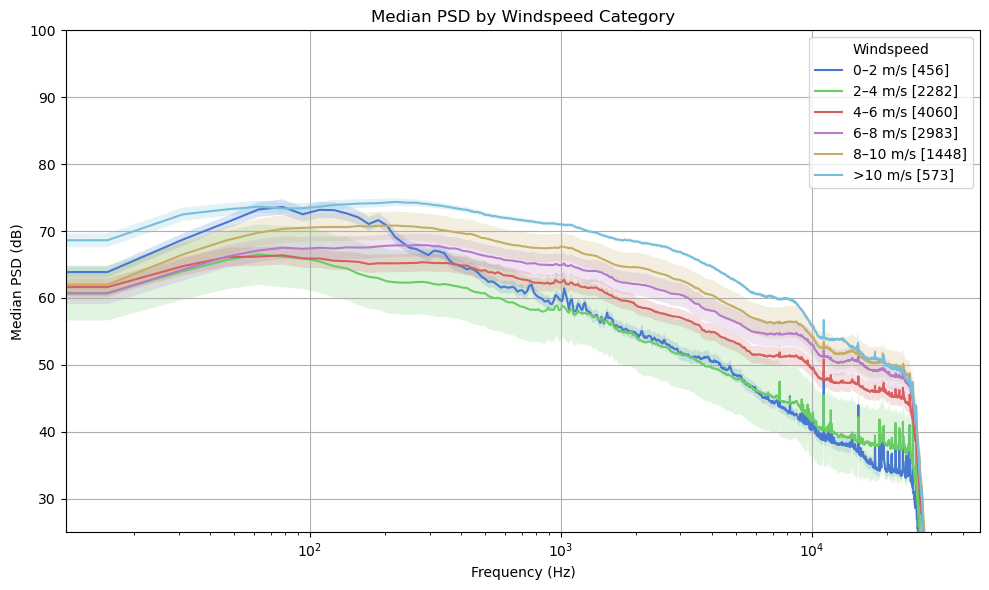

In [17]:
# Define windspeed categories as (label, min, max)
categories = [
    ('0–2 m/s', 0, 2),
    ('2–4 m/s', 2, 4),
    ('4–6 m/s', 4, 6),
    ('6–8 m/s', 6, 8),
    ('8–10 m/s', 8, 10),
    ('>10 m/s', 10, np.inf)
]

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-muted')

for label, wmin, wmax in categories:
    # Filter rows in windspeed range
    group_df = df[(df['windspeed'] >= wmin) & (df['windspeed'] < wmax)]

    # Collect aligned PSDs (same length and frequency)
    psd_list = []
    freq_ref = None

    for _, row in group_df.iterrows():
        freq = row['frequency']
        psd = row['psd']

        if freq and psd:
            if freq_ref is None:
                freq_ref = freq
            if len(freq) == len(freq_ref) and np.allclose(freq, freq_ref):
                psd_list.append(psd)

    # Calculate median if any data available
    if psd_list:
        psd_array = np.array(psd_list)
        median_psd = np.median(psd_array, axis=0)
        std_psd = np.std(psd_array, axis=0)
        
        # Plot median line
        plt.plot(freq_ref, median_psd, label=label+' [' +str(len(psd_array))+']')

        # Plot shaded region for ±1/8 standard deviation
        plt.fill_between(freq_ref, median_psd - std_psd/8, median_psd + std_psd/8, alpha=0.2)

# Final plot settings
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Median PSD (dB)')
plt.title('Median PSD by Windspeed Category')
plt.ylim(25, 100)
plt.grid(True)
plt.legend(title='Windspeed')
plt.tight_layout()
plt.show()


# Fit Two-Segment Linear Model to PSD at 5 kHz vs. Wind Speed

In this cell, we fit a piecewise linear regression model to analyze the relationship between underwater noise levels (PSD at 5 kHz) and surface wind speed. Using `scipy.optimize.curve_fit`, we fit two linear segments that intersect at a breakpoint (also optimized). This allows us to identify different noise regimes, such as a wind-independent baseline and a wind-driven increase in noise. The fitted model is then plotted alongside the data as two dashed black lines. 

This section egenrates a plot similar to Figure 9 in [this paper](https://pubs.aip.org/asa/jasa/article/150/6/4166/993696/Statistical-analysis-and-modeling-of-underwater) 


/tmp/ipykernel_667/1792158663.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, log_ws, psd_at_5kHz, p0=p0)


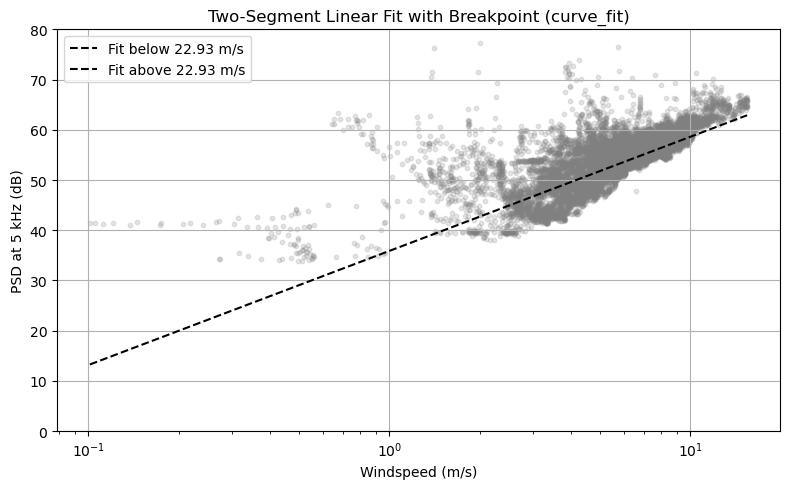

In [18]:
# Prepare data
target_freq = 5000  # Hz
wind_speeds = []
psd_at_5kHz = []

for _, row in df.iterrows():
    freq = row['frequency']
    psd = row['psd']
    wind = row['windspeed']

    if freq is not None and psd is not None:
        freq = np.array(freq)
        psd = np.array(psd)
        if len(freq) == len(psd):
            idx = np.argmin(np.abs(freq - target_freq))
            wind_speeds.append(wind)
            psd_at_5kHz.append(psd[idx])

wind_speeds = np.array(wind_speeds)
psd_at_5kHz = np.array(psd_at_5kHz)

# Remove non-positive wind speeds for log scale
valid = wind_speeds > 0
wind_speeds = wind_speeds[valid]
psd_at_5kHz = psd_at_5kHz[valid]
log_ws = np.log10(wind_speeds)

# Define continuous piecewise linear model
def piecewise_linear(logx, bp, slope1, intercept1, slope2):
    """Two-piece linear model with continuity at breakpoint bp."""
    y = np.zeros_like(logx)
    left = logx < bp
    right = ~left

    y[left] = slope1 * (logx[left]) + intercept1
    y[right] = slope2 * (logx[right] - bp) + (slope1 * bp + intercept1)  # force continuity

    return y

# Initial guess: [breakpoint, slope1, intercept1, slope2]
p0 = [np.median(log_ws), 10, 40, 5]

# Fit the model
params, _ = curve_fit(piecewise_linear, log_ws, psd_at_5kHz, p0=p0)
bp_opt, slope1_opt, intercept1_opt, slope2_opt = params

# Generate fits
x_fit = np.linspace(log_ws.min(), log_ws.max(), 200)
y_fit = piecewise_linear(x_fit, *params)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(wind_speeds, psd_at_5kHz, color='gray', s=10, alpha=0.2)

# Plot fit lines
x1 = x_fit[x_fit < bp_opt]
x2 = x_fit[x_fit >= bp_opt]
y1 = piecewise_linear(x1, *params)
y2 = piecewise_linear(x2, *params)
plt.plot(10**x1, y1, 'k--', label=f'Fit below {10**bp_opt:.2f} m/s')
plt.plot(10**x2, y2, 'k--', label=f'Fit above {10**bp_opt:.2f} m/s')

plt.xscale('log')
plt.ylim(0, 80)
plt.xlabel('Windspeed (m/s)')
plt.ylabel('PSD at 5 kHz (dB)')
plt.title('Two-Segment Linear Fit with Breakpoint (curve_fit)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 🔍 Activity: Compare Oregon Offshore and Shelf Acoustic Data
Explore and compare underwater acoustic data recorded at two different locations off the Oregon coast: **Oregon offshore** and **Oregon shelf**. Analyze how environmental conditions, such as wind, influence the acoustic spectra at each site.
